In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Dropout, Normalization, BatchNormalization, LayerNormalization, Input

from sklearn.preprocessing import MinMaxScaler

In [146]:
df = pd.read_parquet("../data/raw/input_dataset-2.parquet")

y = df.iloc[:, 8:14]
X = df.drop(columns=y)

In [147]:
X.describe()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Steel tmp,Bolt_1_Torsion,Bolt_2_Torsion,Bolt_3_Torsion,Bolt_4_Torsion,Bolt_5_Torsion,Bolt_6_Torsion,lower_bearing_vib_vrt,turbine_bearing_vib_vrt
count,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.068018e+06,1.068018e+06
mean,2.977542e+02,5.989380e+00,9.105910e+01,1.577165e+02,5.312681e+03,1.079521e+02,3.185047e+00,1.784819e+02,1.657813e+02,1.462637e+02,2.257179e+02,2.986768e+02,1.618114e+02,1.454601e-01,4.567642e-01
std,3.387414e+01,8.155810e+00,8.714153e+00,1.909088e+01,2.990343e+01,2.902935e+00,4.765675e-01,2.019696e+00,4.113352e+00,2.145015e-01,2.001803e-01,7.708676e-01,3.447038e-01,2.508660e-02,2.421547e-01
min,0.000000e+00,-3.811665e+01,0.000000e+00,1.353587e+02,3.621803e+03,6.264306e-01,2.402152e+00,1.753436e+02,1.629430e+02,1.457152e+02,2.243099e+02,2.977115e+02,1.608971e+02,5.138796e-02,1.300494e-01
25%,3.069059e+02,0.000000e+00,9.331226e+01,1.488042e+02,5.298511e+03,1.080113e+02,2.805074e+00,1.768119e+02,1.632180e+02,1.460956e+02,2.256090e+02,2.980816e+02,1.616467e+02,1.363742e-01,4.458940e-01
50%,3.098457e+02,6.300167e+00,9.404115e+01,1.516418e+02,5.303462e+03,1.080553e+02,3.176576e+00,1.783134e+02,1.642139e+02,1.463355e+02,2.257666e+02,2.985405e+02,1.618121e+02,1.467246e-01,4.788169e-01
75%,3.112799e+02,1.117088e+01,9.448438e+01,1.566876e+02,5.316882e+03,1.080889e+02,3.505450e+00,1.796520e+02,1.655471e+02,1.464563e+02,2.258674e+02,2.990896e+02,1.620740e+02,1.555545e-01,4.995086e-01
max,3.233023e+02,4.910232e+01,9.618052e+01,2.734938e+02,5.512772e+03,1.083688e+02,4.611985e+00,1.834105e+02,1.788814e+02,1.471180e+02,2.260519e+02,3.012224e+02,1.629766e+02,1.355756e+00,5.316383e+01


# Mode to binary

In [148]:
X["is_starting"] = X["mode"].replace("operation", 0).replace("start", 1)

## Netto Power: Unit_4_Power - Unit_4_Reactive Power

In [149]:
X["Netto Power"] = X["Unit_4_Power"] - X["Unit_4_Reactive Power"]

# Unit_4_Power / Vane opening

In [150]:
X["Power / vane opening"] = X["Unit_4_Power"] / X["Turbine_Guide Vane Opening"]

# Active_turbine_cumsum (sec)

In [151]:
X["startnr"] = (X["is_starting"]==1).cumsum()
X["seconds_since_last_data"] = pd.Series(X.index, index=X.index).diff().dt.seconds
X["seconds_since_last_start"] = X.groupby("startnr")["seconds_since_last_data"].cumsum()
X.loc[X["is_starting"]==1, "seconds_since_last_start"] = 0

# Turbine Bearing Vibration / turbine speed

In [152]:
X["turbine_bearing_vib / speed"] = X["turbine_bearing_vib_vrt"] / X["Turbine_Rotational Speed"]

# Power / Drafttube Pressure

In [153]:
X["Power / Drafttube pressure"] = X["Unit_4_Power"] / X["Turbine_Pressure Drafttube"]

<AxesSubplot:xlabel='timepoints'>

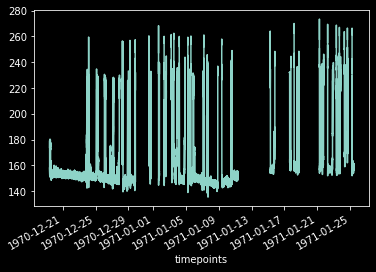

In [154]:
X["Turbine_Pressure Drafttube"].plot()

In [155]:
X.describe()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Steel tmp,Bolt_1_Torsion,Bolt_2_Torsion,Bolt_3_Torsion,...,lower_bearing_vib_vrt,turbine_bearing_vib_vrt,is_starting,Netto Power,Power / vane opening,startnr,seconds_since_last_data,seconds_since_last_start,turbine_bearing_vib / speed,Power / Drafttube pressure
count,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,1.750000e+06,...,1.068018e+06,1.068018e+06,1.874087e+06,1.750000e+06,1.749962e+06,1.874087e+06,1.874086e+06,1.874086e+06,943931.000000,1.750000e+06
mean,2.977542e+02,5.989380e+00,9.105910e+01,1.577165e+02,5.312681e+03,1.079521e+02,3.185047e+00,1.784819e+02,1.657813e+02,1.462637e+02,...,1.454601e-01,4.567642e-01,2.896344e-03,2.917649e+02,3.254471e+00,1.848639e+03,1.477682e+00,1.071424e+05,0.004709,1.927175e+00
std,3.387414e+01,8.155810e+00,8.714153e+00,1.909088e+01,2.990343e+01,2.902935e+00,4.765675e-01,2.019696e+00,4.113352e+00,2.145015e-01,...,2.508660e-02,2.421547e-01,5.373971e-02,3.032744e+01,1.962569e-01,1.630256e+03,1.513309e+02,1.030651e+05,0.028657,3.295913e-01
min,0.000000e+00,-3.811665e+01,0.000000e+00,1.353587e+02,3.621803e+03,6.264306e-01,2.402152e+00,1.753436e+02,1.629430e+02,1.457152e+02,...,5.138796e-02,1.300494e-01,0.000000e+00,-2.832697e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.001832,0.000000e+00
25%,3.069059e+02,0.000000e+00,9.331226e+01,1.488042e+02,5.298511e+03,1.080113e+02,2.805074e+00,1.768119e+02,1.632180e+02,1.460956e+02,...,1.363742e-01,4.458940e-01,0.000000e+00,2.941981e+02,3.273256e+00,2.160000e+02,1.000000e+00,2.134700e+04,0.004084,1.975358e+00
50%,3.098457e+02,6.300167e+00,9.404115e+01,1.516418e+02,5.303462e+03,1.080553e+02,3.176576e+00,1.783134e+02,1.642139e+02,1.463355e+02,...,1.467246e-01,4.788169e-01,0.000000e+00,3.004058e+02,3.289016e+00,2.106000e+03,1.000000e+00,6.686100e+04,0.004404,2.044560e+00
75%,3.112799e+02,1.117088e+01,9.448438e+01,1.566876e+02,5.316882e+03,1.080889e+02,3.505450e+00,1.796520e+02,1.655471e+02,1.464563e+02,...,1.555545e-01,4.995086e-01,0.000000e+00,3.056284e+02,3.298681e+00,3.187000e+03,1.000000e+00,1.767420e+05,0.004598,2.086106e+00
max,3.233023e+02,4.910232e+01,9.618052e+01,2.734938e+02,5.512772e+03,1.083688e+02,4.611985e+00,1.834105e+02,1.788814e+02,1.471180e+02,...,1.355756e+00,5.316383e+01,1.000000e+00,3.326107e+02,3.405552e+00,5.428000e+03,8.059400e+04,3.965850e+05,5.401658,2.383355e+00


<AxesSubplot:>

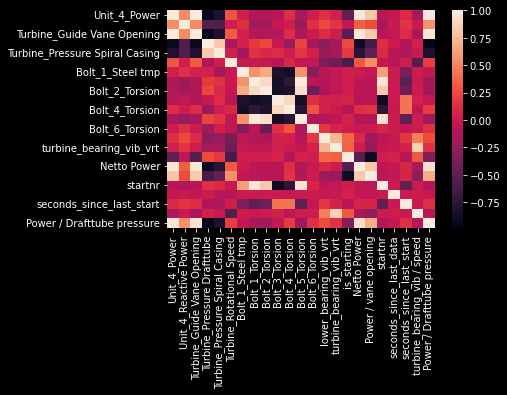

In [156]:
sns.heatmap(X.corr())

<AxesSubplot:xlabel='timepoints'>

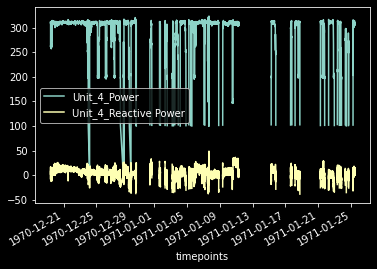

In [157]:
X[["Unit_4_Power", "Unit_4_Reactive Power"]].plot()